### Prepare space in flash

In [1]:
import os, subprocess

In [2]:
resultdir = "/bucket/ReiterU/DBS/analysis/220824_sup_fig_atlas"
if not os.path.exists(resultdir):
    subprocess.run(["ssh", "deigo", "mkdir", resultdir])

In [3]:
cwd = os.path.basename(os.getcwd())
tmpdir = os.path.join("/flash/ReiterU/tmp/", cwd, "mosaic_sections")
if not os.path.exists(tmpdir):
    os.makedirs(tmpdir)

In [4]:
from probemapper.io import load_nifti
from matplotlib import pyplot as plt
import nrrd
import numpy as np
import pandas as pd
from scipy import ndimage as ndi

In [5]:
# Load raw image
vol = load_nifti("/bucket/ReiterU/DBS/atlas/O_Laqueus_v0.1/nuclear_10um.nii")
mask = load_nifti("/bucket/ReiterU/DBS/atlas/O_Laqueus_v0.1/nuclear_10um_mask.nii.gz")
vol[mask==0] = 0

# crop
vol = vol[70:, 30:440, 25:435]
# rotation
vol = ndi.rotate(vol, 225, axes=(0,1), reshape=False, order=3)
vol = ndi.rotate(vol, 5, axes=(0,2), reshape=False, order=3)

# flip
vol = vol[:, ::-1, :]
vol = vol.astype("float")

# normalize intensity in range [0,1]
vol = (vol / 10000).clip(0,1)

# gamma correction
vol = np.power(vol, 1/2.0)

print(vol.shape)

(410, 410, 410)


In [6]:
# load annotation
ann, _ = nrrd.read("/bucket/ReiterU/DBS/atlas/O_Laqueus_v0.1/Slicer_3D/Segmentation.seg.nrrd")
ann = np.swapaxes(ann, 0, 2)

# ID 3 = others
ann[ann==3] = 0

# crop
ann = ann[70:, 30:440, 25:435]
# rotation
ann = ndi.rotate(ann, 225, axes=(0,1), reshape=False, order=0)
ann = ndi.rotate(ann, 5, axes=(0,2), reshape=False, order=0)
# flip
ann = ann[:, ::-1, :]

In [7]:
lut = pd.read_csv("/bucket/ReiterU/DBS/atlas/O_Laqueus_v0.1/region_LUT.csv")
display(lut)

,ID,region_name,region_color
0,1,Vertical Lobe,"128,174,128"
1,3,Others,"216,100,79"
2,4,Median superior frontal lobe + Lateral superio...,"216,100,79"
3,5,Median inferior frontal lobe + Lateral inferio...,"255,147,114"
4,6,Superior buccal lobe\n+ Posterior buccal lobe,"244,128,26"
5,7,Subfrontal lobe,"251,202,0"
6,8,Anterior basal lobe,"89,114,255"
7,9,Anterior dorsal basal lobe + Posterior dorsal ...,"82,145,163"
8,11,Subvertical Lobe,"24,151,54"
9,12,Precomissural,"255,170,255"


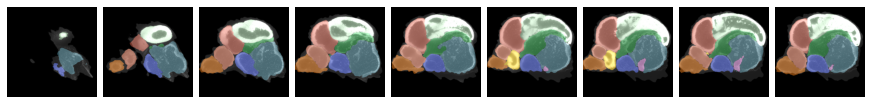

In [8]:
alpha = 0.5

fig, axs = plt.subplots(1,9, figsize=(12,5), constrained_layout=True)

for (i, sl) in enumerate(np.arange(70, 231, 20)):
    rgb = np.stack((vol[:,:,sl],)*3, axis=-1)
    ann_2d = ann[:,:,sl]
    for index, row in lut.iterrows():
        region_id = row["ID"]
        color = [int(x) for x in row["region_color"].split(',')]
        color = tuple([v/255 for v in color])
        rgb[:,:,0] += (ann_2d == region_id) * alpha * color[0]
        rgb[:,:,1] += (ann_2d == region_id) * alpha * color[1]
        rgb[:,:,2] += (ann_2d == region_id) * alpha * color[2]
    
    rgb = rgb.clip(0,1)
    axs[i].imshow(rgb)
    axs[i].axis("off")
    #axs[i].set_title(f"X = {sl*10} um")

# plt.savefig(os.path.join(tmpdir, "sagitall_sections.png"), dpi=300, bbox_inches="tight")
plt.savefig(os.path.join(tmpdir, "sagitall_sections.pdf"), dpi=300, bbox_inches="tight")
plt.show()

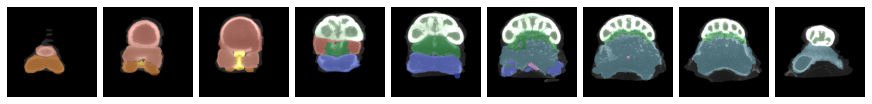

In [9]:
alpha = 0.5

fig, axs = plt.subplots(1,9, figsize=(12,5), constrained_layout=True)

for (i, sl) in enumerate(np.arange(50, 390, 40)):
    rgb = np.stack((vol[:,sl,:],)*3, axis=-1)
    ann_2d = ann[:,sl,:]
    for index, row in lut.iterrows():
        region_id = row["ID"]
        color = [int(x) for x in row["region_color"].split(',')]
        color = tuple([v/255 for v in color])
        rgb[:,:,0] += (ann_2d == region_id) * alpha * color[0]
        rgb[:,:,1] += (ann_2d == region_id) * alpha * color[1]
        rgb[:,:,2] += (ann_2d == region_id) * alpha * color[2]
    
    rgb = rgb.clip(0,1)
    axs[i].imshow(rgb)
    axs[i].axis("off")
    #axs[i].set_title(f"Y = {sl*10} um")

# plt.savefig(os.path.join(tmpdir, "coronal_sections.png"), dpi=300, bbox_inches="tight")
plt.savefig(os.path.join(tmpdir, "coronal_sections.pdf"), dpi=300, bbox_inches="tight")
plt.show()

### Copy data to bucket

In [10]:
subprocess.run(["scp", "-r", tmpdir, f"deigo:{resultdir}"])

CompletedProcess(args=['scp', '-r', '/flash/ReiterU/tmp/220824_sup_fig_atlas/mosaic_sections', 'deigo:/bucket/ReiterU/DBS/analysis/220824_sup_fig_atlas'], returncode=0)